# Introduction to Digital Forensics - Assignment 3
### Motivation and Goals

In this report we will investigate chats from a ransomware group called Conti. This report will analyze different aspects from these chats and provide a report for the FBI. 

### Methodology and Results

The chats have been provided to us by our teacher. We will use different techniques to extract useful information from the chats. The techniques used to extract this data are by using python, and Excel for people who are less skillful at programming.


### Made by group 1:
- Simge Bilen       s2532239
- Mark Boom         s2552469
- Tom Essers        s2484765
- Baran Gülbey      s2616394
- Jelmer Hofman     s2460653
- Stijn Schuurman   s2620162

In [52]:
!pip3 install pandas
!pip3 install matplotlib
!pip3 install openpyxl
!pip3 install tabulate


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python3.10 -m pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python3.10 -m pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python3.10 -m pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import collections
from tabulate import tabulate


import os
import csv
import datetime
import dataclasses
from collections import defaultdict
from re import A
from typing import Optional, List, Tuple


FILE = 'jabber_chat_2021_2022_translated.csv'


class Chat:

    @dataclasses.dataclass
    class Message:

        timestamp: datetime.datetime
        sender: str
        receiver: str
        body_original: str
        body_translated: str
        language: Optional[str]

    def __init__(self, source_file):
        self.idx = -1
        self.messages = []
        with open(source_file, encoding="UTF-8") as fp:
            reader = csv.DictReader(fp)
            for row in reader:
                self.messages.append(self.Message(
                    timestamp=datetime.datetime.fromisoformat(row['ts']),
                    sender=row['sender'],
                    receiver=row['to'],
                    body_original=row['body'],
                    body_translated=row['body_en'],
                    language=row['body_language'] or None,
                ))

    def __iter__(self):
        return iter(self.messages)

    def get_full(self, translation: bool = True):
        if translation:
            return '\n'.join(f' {m.body_translated} ' for m in self)
        return '\n'.join(f' {m.body_original} ' for m in self)


def get_bad_words() -> List[Tuple[str, bool]]:
    with open('swearwords.txt', encoding="UTF-8") as fp:
        swearwords = [
            (x.split(' 1')[0], x.endswith(' 1'))
            for x in fp.read().split('\n') if x and not x.startswith('#')
        ]
    return swearwords


def get_movie_titles() -> List[str]:
    with open('imdb_top_1000.csv', encoding="UTF-8") as fp:
        reader = csv.DictReader(fp)
        movies = [x['Series_Title'] for x in reader]
    return movies


def get_words() -> List[str]:
    with open('words.txt', encoding="UTF-8") as fp:
        words = [x for x in fp.read().split('\n') if x and not x.startswith('#')]
    return words


chat = Chat(FILE)

In [54]:
#csv file
file =  'jabber_chat_2021_2022_translated.csv'

df = pd.read_csv(file)

## (1) How many bad words are in the messages?
Our hackers definitely did say the naughty words. We found a list of 60 English swearwords and matched them against the messages in a case-insensitive manner. Some swearwords could be part of a larger word (**fuckers** will match the swearword **fuck**), while other swearwords (like **hell**) are only counted by themselves (to avoid mathing **hello**, for example). Top 3 hacker swear words? Those were **fuck** (650 times), **damn** (145 times) and **shit** (117 times).

In [55]:
bad_words = {(w, p): 0 for w, p in get_bad_words()}
for message in chat:
    for (word, partial) in bad_words:
        lookup = word
        if not partial:
            lookup = f' {word} '
        bad_words[(word, partial)] += len(message.body_translated.lower().split(lookup.lower())) - 1
usage = sorted([(b, a) for a, b in bad_words.items()], reverse=True)
print(f'Top 10 bad words:\n{os.linesep.join(f"{b} - {a} times" for a, (b, _) in usage[0:10])}\n')

Top 10 bad words:
fuck - 650 times
damn - 145 times
shit - 117 times
arse - 79 times
hell - 54 times
bitch - 45 times
dick - 37 times
bullshit - 37 times
damn it - 26 times
piss - 17 times



## (2) In what time zones do the hackers probably live?
For this research question, we assumed recorded times are in UTC. We have no way to verify this, however, so this should be taken into consideration when making conclusions. For each user, we took all hours of the day they sent out messages. We assumed the weighted average of these hours to be noon for the user. That is again, an assumption as this might skew the results for users who are primarily active at night or in the morning. Using this data, we can then determine the UTC offset for each user. Results? The most popular offset (78 users) was +2, followed by +1 (49 users). Considering our target group is primarily Russian and Eastern-European these time zones do make sense.

In [56]:
hours_per_sender = defaultdict(list)
for message in chat:
    hours_per_sender[message.sender].append(message.timestamp.hour)
averages = {sender: sum(hours) // len(hours) for sender, hours in hours_per_sender.items()}
average_counts = {a: 0 for a in averages.values()}
for hour in averages.values():
    average_counts[hour] += 1
usage = sorted([(b, a) for a, b in average_counts.items()], reverse=True)
print(f'Top 5 UTC offsets:\n{os.linesep.join(f"{b - 12}h - {a} users" for a, b in usage[0:5])}\n')

Top 5 UTC offsets:
2h - 78 users
1h - 49 users
3h - 34 users
0h - 33 users
-2h - 23 users



## (3) At what time are the hackers the most active?
We wanted to know during what times the hackers were most active. The graph below indicates that most of the chats were sent during the hours between 12:00 and 17:00, which can be seen as the normal working hours.

(array([ 313.,  408.,  321.,  388.,  249.,  531.,  839., 1977., 2759.,
        3221., 3200., 3582., 4503., 5233., 5257., 4545., 4723., 4946.,
        4393., 3089., 2940., 1952., 1404.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.]),
 <BarContainer object of 23 artists>)

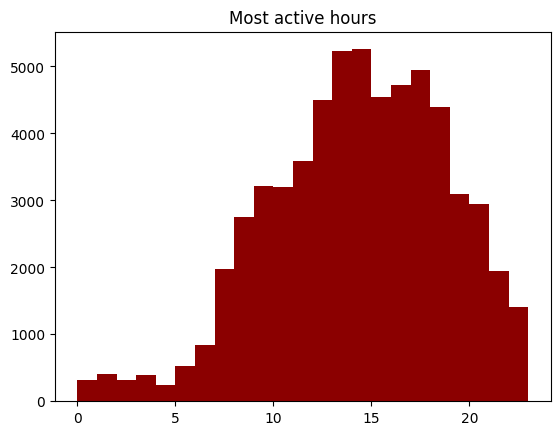

In [57]:
df = pd.read_csv(file, usecols=['ts'])
hours = []
for index, row in df.iterrows():
    hours.append(int(row.ts[11:13]))
plt.title("Most active hours")
plt.hist(hours, color="darkred", bins=range(0, 24))

## (4) What are the most commonly used words not present in a dictionary?
Our hackers don’t always stick to dictionary words: as we all know, the language on the internet is simply different sometimes. We compiled a list of 3000 common English words. From there on, we matched those words to chat messages. Then, we added words to the top of the list that were high-scoring valid English dictionary words. This allowed us to select some non-dictionary words that the hackers commonly used. Most prominently: various variations of **crypto** (1.116 times in total), followed by **bro** (810 times). We don’t say thank you and please, but rather opt for **plz** in the chatroom. The word **dll** appeared several times as well; this might be linked to the phenomenon “Dynamic Link Libraries” in Windows; commonly needed when developing innocent software - or ransomware.


In [58]:
common_words = get_words()
uncommon_words = defaultdict(int)
for message in chat:
    for word in message.body_translated.lower().split(' '):
        if word not in common_words and word.isalpha():
            uncommon_words[word] += 1
usage = sorted([(b, a) for a, b in uncommon_words.items()], reverse=True)
print(f'Top 20 unusual words:\n{os.linesep.join(f"{b} - {a} times" for a, b in usage[0:20])}\n')

Top 20 unusual words:
bro - 810 times
crypto - 448 times
crypt - 349 times
crypts - 319 times
admin - 311 times
ky - 308 times
lags - 298 times
dll - 266 times
plz - 246 times
binance - 245 times
bots - 237 times
polkadot - 236 times
dex - 236 times
rocket - 233 times
principles - 233 times
am - 233 times
successes - 225 times
got - 209 times
guru - 196 times
acc - 190 times



## (5) Who sends the most messages?
In order to know who were most active in the hacker group, we wanted to know who was responsible for sending the most messages. The graph indicates that this was, by far, a user who called themselves *defender*

<BarContainer object of 10 artists>

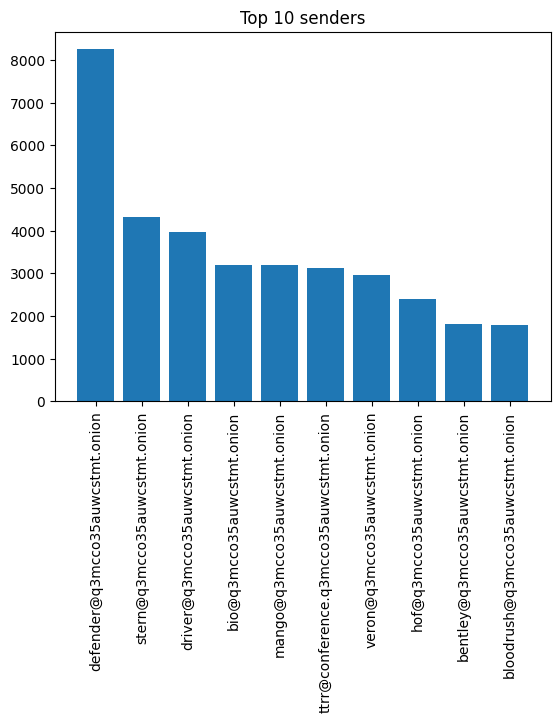

In [59]:
df = pd.read_csv(file, usecols=['sender'])
senders = []
for index, row in df.iterrows():
    senders.append(row.sender)

frequency = collections.Counter(senders)

sendersList = frequency.keys()
frequencyList = frequency.values()

sendersOrdered = [x for _,x in sorted(zip(frequencyList,sendersList), reverse=True)]
frequenciesOrdered = []
# Z is ordered list of most used emails as senders
for x in sendersOrdered:
    frequenciesOrdered.append(frequency.get(x))

plt.title("Top 10 senders")
plt.xticks(rotation=90)
plt.bar(sendersOrdered[:10], frequenciesOrdered[:10])

## (6) Who receives the most messages?
A possible indication of who could be the leader of the hacker group, we assumed that it was possible that this was the person who received the most messages. The graph indicates that this is the same person who sent the most messages, namely *defender*.

<BarContainer object of 10 artists>

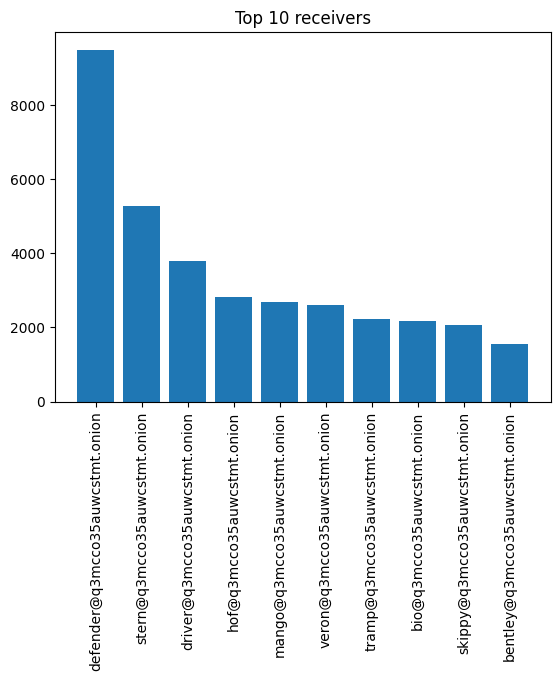

In [60]:
df = pd.read_csv(file, usecols=['to'])
receivers = []
for index, row in df.iterrows():
    receivers.append(row.to)

frequency = collections.Counter(receivers)

receiversList = frequency.keys()
frequencyList = frequency.values()

sendersOrdered = [x for _,x in sorted(zip(frequencyList,receiversList), reverse=True)]
frequenciesOrdered = []
# Z is ordered list of most used emails as senders
for x in sendersOrdered:
    frequenciesOrdered.append(frequency.get(x))

plt.title("Top 10 receivers")
plt.xticks(rotation=90)
plt.bar(sendersOrdered[:10], frequenciesOrdered[:10])

## (7) What are some movies or songs the hackers reference?
Our hackers aren’t really fans of movies, it seems. We’ve checked the chat logs against a list of 1000 popular movies and television shows on IMDB, but found no relevant direct mentions. We checked again in a case-insensitive manner and required movie names to be present in full (**driver** does not match the movie **Drive**). After analyzing the results, at first it seems hackers are really fond of Disney’s **Up**, however logical thinking makes us conclude that the word “Up” is quite commonly used in the English language. Searching for movie titles that are not dictionary words yields no relevant results. However, for this approach it’s important to also take into account the fact that these messages were translated from other languages (mostly Russian). This may skew the results a bit, as both the range of movies viewed in Russia differs a little as well as there is a high probability that the translation engine will not produce exact movie names.

In [61]:
movies = {m: 0 for m in get_movie_titles()}
chat_full = chat.get_full().lower()
for movie in movies:
    movies[movie] += len(chat_full.split(f' {movie.lower()} ')) - 1
usage = sorted([(b, a) for a, b in movies.items()], reverse=True)
print(f'Top 20 referenced movies:\n{os.linesep.join(f"{b} - {a} times" for a, b in usage[0:20])}\n')

Top 20 referenced movies:
The Message - 14409 times
Up - 690 times
Her - 172 times
Once - 139 times
Network - 108 times
Crash - 72 times
Saw - 48 times
Drive - 41 times
Taken - 38 times
Control - 36 times
Black - 33 times
Searching - 21 times
Ran - 21 times
The Social Network - 19 times
Pink - 19 times
300 - 16 times
Get Out - 14 times
Room - 9 times
Wonder - 8 times
The General - 8 times



## (8) Bitcoin wallets that are mentioned 
Hackers in general work a lot with crypto currencies, the victims of the hackers have to pay in crypto and the employees within the hacker group have their salaries paid out in crypto’s. Is this also the case for the hacker group ‘Conti’? To find this out the column of ‘body’ was taken (the messages, non translated), and then filtered for a Bitcoin address. To find all the bitcoin address we first have to find out what a bitcoin address looks like, so we can properly identify them within the tens of thousands messages. We found out that a bitcoin address starts with the character ‘1’, ‘3’ or ‘b’, and they are not shorter than 27 characters and not longer than 34. This information is enough to iterate through every row of the column and find every bitcoin wallet. We did this and as expected we found alot of mentioned wallet addresses, 118 mentions in total which consists of 44 unique wallets. We saw that some addresses were sent multiple times, so we wanted to also find out how many times each wallet has been sent and the wallet that has been sent the most times. “3ESoHHu87mTrFNSNUaMVEfT3vYwRYGfSHQ” has been sent 40 times in total, which is significantly more than every other wallet, with the second highest being mentioned ‘only’ 7 times. This could be one of the main wallets of Conti, however this is just a heavy speculation. 26 wallets have been sent only once. The unique addresses and the frequency they have been mentioned is printed out nicely in a table in the jupyter notebook.

In [62]:
# Receives a string and splits it up at every whitespace. Than iterates over every word so it finds every potential wallet
# Finds all word strings that could potentially be a bitcoin wallet, and returns if a match has been made.
def potentialWalletFinder(stringOfCell):
    cryptoBegin = ["1", "3", "b"] # Bitcoin wallets normally start with these characters
    splittedCell = stringOfCell.split(' ')
    for word in splittedCell:
        if len(word) > 1: # Check if word is actually a word and not a single character
            if word[0] in cryptoBegin: # Check if the first character of the word is that of a potential bitcoin wallet
                if len(word) in range(31, 35): # Officieel tussen 27 en 34 length bitcoin wallet
                    return word
    return 0                

# There are alot of repeat messages in the cvs file which we definitly know it does not include a bitcoin wallet, so we filter those out initially.
def cleanUp(unCleanedString):
    errorStrings = ["[ERROR: This message is encrypted, and you are unable to decrypt it.]", "[Ошибка: сообщение зашифровано, и невозможно его расшифровать.]","[Error: The message is encrypted and cannot be decrypted.]"] #encrypted messages
    unwantedSubstrings = ["-----BEGIN PGP PUBLIC KEY BLOCK-----", ".onion", "192.168.", "188.130."] # Lots of repeated words
    if unCleanedString in errorStrings:
        return 0
    for index in unwantedSubstrings:
        if index in unCleanedString:
            return 0
    return unCleanedString

# Turn the list of unique wallets into a list of lists so it can be turned into a table, connect the frequency with every unique wallet address
def setTable(unique, frequency):
    tableFormatted = []
    count = 0
    for index in unique:
        tempList = []
        tempList.append(count + 1)
        tempList.append(index)
        tempList.append(frequency[count])  
        count += 1
        tableFormatted.append(tempList)
    return tableFormatted

# Defining a method which gets the wallets from a cvs
def getWallets(dataFile):
    df = pd.read_csv(dataFile, usecols=['body']) # Read all rows in the body column
    wallets = []
    for index, row in df.iterrows():
        cleanedUp = cleanUp(row.body)
        if cleanedUp != 0:
            temp = potentialWalletFinder(cleanedUp)
            if temp != 0:
                wallets.append(temp)
    return wallets

# Defining a method which gets the unique wallets from a cvs
def getUniqueWallets(dataFile):
    df = pd.read_csv(dataFile, usecols=['body']) # Read all rows in the body column
    wallets = []
    for index, row in df.iterrows():
        cleanedUp = cleanUp(row.body)
        if cleanedUp != 0:
            temp = potentialWalletFinder(cleanedUp)
            if temp != 0:
                if temp not in wallets:
                    wallets.append(temp)
    return wallets

# Method to find out how many times each wallet address are within the cvs file
def getWalletFrequency(wallets, unique):
    frequency = []
    for i in unique:
        frequency.append(wallets.count(i))
    return frequency

unique = getUniqueWallets(file)
frequency = getWalletFrequency(getWallets(file), unique)
print(tabulate(setTable(unique, frequency), headers=["Nr.", "Bitcoin address", "Frequency"]))

  Nr.  Bitcoin address                       Frequency
-----  ----------------------------------  -----------
    1  3ESoHHu87mTrFNSNUaMVEfT3vYwRYGfSHQ           40
    2  1PemRXvQ5nbDs6q19pCUzfd4kXVGovVoe3            3
    3  1                                             1

       [allen]
       15.06.2021
       отпуск
       не
    4  14HnaQfsQdtgVSNR91jLcbcKtdyddDfP6D            2
    5  15gjb8F5Zd8XRKBCgVxsr8ZuVzr7yBtnCN            1
    6  1DSp4woswZECAL9zdmmGeu1s7k1sGExFDh            5
    7  1HtyXyCrshiJmLYNru7atpDMJrzG9mzwzf            5
    8  b58c7d4c1824eefc874dd7f07eacec58              1
    9  1KfDPgc6CiWb6Fnin1bLWi2moX1ViXANxW            4
   10  1AXiwETqqQoA52Jk5CmJkbAPuW8nR7VUYz            1
   11  1hLvH27BxAPbqx3R2fMCuuMPfS2gGDBJL             1
   12  3N4oho2uXfkFBfUAPtoPGLUXjHXqXV4vrJ            7
   13  1347fBtFzZCrPq29yjRpct5f6Kq5uHZHHy            1
   14  36UqDj8hGfZTVjpURvSnKtpJnJKjhYcvuY            1
   15  314f41b2d78ec803c74a2c89fa8e8bb4              2
   16  

## (9) Can we find personal bitcoin wallets?
After searching for and finding a couple of dozen bitcoin wallet addresses, we wanted to find out about the users sending them and maybe find a personal wallet of an user. We first mapped every bitcoin wallet address that is mentioned to the sender (a notion email address), which then was printed. Looking at this we could analyze much, so we made some functions which prints out the users one by one and the wallet addresses they have mentioned. We also added a function that tells how many times they mentioned that particular address and also if any other user mentioned that particular address even once. Using all this information we can see if an address is only mentioned by one user or multiple, and if they mention it only once or multiple times. Following this we found out multiple things: the most mentioned wallet (part 8) is sent 38 times out of 40 by the user: “many@q3mcco35auwcstmt.onion”, and two times by one other user. We find out that only two wallet addresses are being shared by two (or more) users, this was a surprise for us because we this could mean that alot of the other addresses could be their personal addresses to receive salary for example, especially the ones that they mention more than once. There are 13 unique users that have mentioned a wallet address at least once, most of them have mentioned more than one different addresses. The user: derekson@q3mcco35auwcstmt.onion has sent the most separate wallets, 7 in total and they have sent all 7 only once and also no other user has mentioned them. 

In [63]:
# Method which returns a formatted list in a list which contains which addressess a sender has used.
def walletToSenderConnector(dataFile):
    df = pd.read_csv(dataFile, usecols=['sender', 'body'])
    formatted = []
    for index, row in df.iterrows():
        cleanedUp = cleanUp(row.body)
        if cleanedUp != 0:
            temp = potentialWalletFinder(cleanedUp)
            if temp != 0:  
               tempList = []  
               tempList.append(row.sender)  
               tempList.append(temp)     
               formatted.append(tempList)
    return formatted

# Method which returns the total amount a sender has send this specific wallet
def howManyTimesSendCounter(sendersList, walletsList, sender, wallet):
    counter = 0
    i = 0
    for index in sendersList:
        if index == sender:
            if walletsList[i] == wallet:
                counter += 1
        i += 1
    return counter

# Method which returns the total amount of users that have also used this wallet, other than the original sender
def isUsedByOtherSender(senderList, walletList, sender, wallet):
    tempSenderList = []
    counter = 0
    i = 0
    for index in walletList:
        if index == wallet:
            if sender != senderList[i]:
                if senderList[i] not in tempSenderList:
                    counter += 1
                    tempSenderList.append(senderList[i])
        i += 1
    return len(tempSenderList)

# Method which gathers all methods and prints the result out on to the console for the analysis
def senderWallets(senders, wallets):
    uniqueSenders = list(dict.fromkeys(senders)) #deletes duplicate senders
    for unique in uniqueSenders:
        i = 0
        tempList = []
        tempList.append(unique)
        print("The user " + unique + " has mentioned the following bitcoin addresses: ") #initial message for each user
        for index in senders:
            if index == unique:
                if wallets[i] not in tempList:
                    timesSend = howManyTimesSendCounter(senders, wallets, index, wallets[i])
                    if timesSend > 1:
                        otherSender = isUsedByOtherSender(senders, wallets, index, wallets[i])
                        if otherSender == 0:
                            print("   - " + wallets[i] + ", " + str(timesSend) + " times, and only sent by this user")
                        else:
                            print("   - " + wallets[i] + ", " + str(timesSend) + " times, and sent by " + str(otherSender) + " other user")
                    else:
                        print("   - " + wallets[i] + ", only once")
                    
                    tempList.append(wallets[i])
            i += 1
        print("_____________________________________________________________________________________________")


uniqueWallets = getUniqueWallets(file)
data = walletToSenderConnector(file)
senders, wallets = map(list, zip(*data))

# print(tabulate(data, headers=["Sender", "Bitcoin address"]) + "\n\n\n") #prints out big table that displays each bitcoin address that has been send and the user that has send it in a message. commented out for clearity
senderWallets(senders, wallets) 


The user many@q3mcco35auwcstmt.onion has mentioned the following bitcoin addresses: 
   - 3ESoHHu87mTrFNSNUaMVEfT3vYwRYGfSHQ, 38 times, and sent by 1 other user
   - 3N4oho2uXfkFBfUAPtoPGLUXjHXqXV4vrJ, 7 times, and only sent by this user
_____________________________________________________________________________________________
The user salamandra@q3mcco35auwcstmt.onion has mentioned the following bitcoin addresses: 
   - 1PemRXvQ5nbDs6q19pCUzfd4kXVGovVoe3, 3 times, and only sent by this user
   - 12V63PHiX8FvEgyewX5W1D2QrdJJSawqQM, 2 times, and only sent by this user
   - 1HFqLt3fbuewZe5ncJautgncS6hN1ZzX5r, 2 times, and only sent by this user
_____________________________________________________________________________________________
The user elon@q3mcco35auwcstmt.onion has mentioned the following bitcoin addresses: 
   - 1

[allen]
15.06.2021
отпуск
не, only once
_____________________________________________________________________________________________
The user bentley@q3mcco35

## (10) Funny messages
Even though this might be one of the biggest hacking groups of the world, however these people working there are all still human. Humour is a big part of the human beings life, these private messages between co-workers might not always be as professional as we think. Funny messages or funny conversations is what we are looking for. Humour is quite subjective and is an emotion, unfortunately computers do not have emotions so we can not automatize the process to find ‘funny’ messages. However we can make a simple function which filters some repetitive messages and prints it so it can be looked through easier manually than just directly from the .csv file. We did this and got to work reading through all lines, some funny messages we found:
“I will be a housewife soon” - It could be meaning they are making alot of money and they could retire soon and become a ‘housewife’.
“some dick” - inappropiate, however self-explanatory.
“maybe stop drinking now” & “maybe quit drinking” - one user sending both messages to the same user, seems funny and random at first however could be a real problem this user is having.
“come on pfizer” & “pfizer infect me” - random, but funny
“I slept for two days” - self-explanatory
“I could hardly resist not to send a dick” - very inappropiate, however quite funny reading this inbetween all the messages. Could be a translation error, i hope.
“well, you need an understanding of how you can be useful to us, what experience do you have there in addition to the crypt, etc.” & “I have the experience of complete freedom of my time and spending it on programming brings me happiness.” - A conversation between two users, not funny however pretty wholesome.
“hello fucking fell asleep yesterday write today we will figure it out” - funny


In [64]:
# Method which filters the column of english messages and prints it out onto the console so it can be manually looked through in the search for funny messages
def funConversations(dataFile):
    df = pd.read_csv(dataFile, usecols=['body_en']) #read all rows in the body column
    cleanMessages = []
    for index, row in df.iterrows():
        cleanedUp = cleanUp(row.body_en)
        if cleanedUp != 0:
            print(row.body_en)

# funConversations(file) # Made this into a comment, because otherwise 50.000 messages will be printed. which is unnecessary after the analysis.        

## (11) On which days were the most messages sent? 
The three days with the most messages were all at the end of August 2021. The funny thing here is that these top three days were at Friday, Monday and Tuesday, meaning that during the weekend not that many messages were sent.

<BarContainer object of 10 artists>

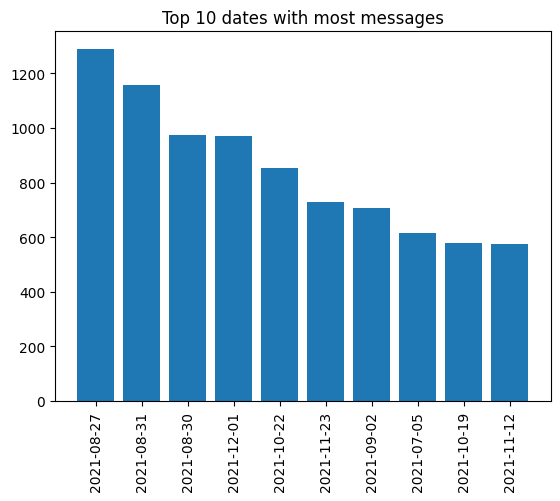

In [65]:
df = pd.read_csv(file, usecols=['ts'])
dates = []

for index, row in df.iterrows():
    dates.append(row.ts.split('T')[0])

frequency = collections.Counter(dates)
datesList = frequency.keys()
frequencyList = frequency.values()

datesOrdered = [x for _,x in sorted(zip(frequencyList, datesList), reverse=True)]
frequenciesOrdered = []
for x in datesOrdered:
    frequenciesOrdered.append(frequency.get(x))

plt.title("Top 10 dates with most messages")
plt.xticks(rotation=90)
plt.bar(datesOrdered[:10], frequenciesOrdered[:10])

## (12) What was the first and last time the top 10 senders sent a message?
Some of the top 10 senders have been sending messages from the beginning until the end of the dataset. These senders are ‘defender’, ‘stern’, ‘mango’, ‘veron’, and ‘bentley’.
Something that stand out is that ‘bloodrush’ only starts messaging in October 2021 and stops in December 2021. In these three months he has become the number 10 of most sent messages.
Even more remarkable is ‘bio’, who has only been active in November and December. In these two months he has sent over 3000 messages (see the graph from “Who sends the most messages?”).


In [66]:
df = pd.read_csv(file, usecols=['sender', 'ts'])
senders = []
for index, row in df.iterrows():
    senders.append(row.sender)

frequency = collections.Counter(senders)
sendersList = frequency.keys()
frequencyList = frequency.values()
sendersOrdered = [x for _,x in sorted(zip(frequencyList, sendersList), reverse=True)]

for x in sendersOrdered[:10]:
    dates = []
    for index, row in df.iterrows():
        if row.sender == x:
            dates.append(row.ts.split('T')[0])
    dates.sort()
    firstlast = []
    firstlast.append(dates[0])
    firstlast.append(dates[-1])
    d = {x: firstlast}
    print(d)

{'defender@q3mcco35auwcstmt.onion': ['2021-01-29', '2022-02-25']}
{'stern@q3mcco35auwcstmt.onion': ['2021-01-29', '2022-02-21']}
{'driver@q3mcco35auwcstmt.onion': ['2021-02-03', '2022-02-10']}
{'bio@q3mcco35auwcstmt.onion': ['2021-11-02', '2021-12-21']}
{'mango@q3mcco35auwcstmt.onion': ['2021-01-29', '2022-02-22']}
{'ttrr@conference.q3mcco35auwcstmt.onion': ['2021-08-27', '2021-12-09']}
{'veron@q3mcco35auwcstmt.onion': ['2021-02-11', '2022-02-25']}
{'hof@q3mcco35auwcstmt.onion': ['2021-02-03', '2021-12-20']}
{'bentley@q3mcco35auwcstmt.onion': ['2021-02-09', '2022-03-01']}
{'bloodrush@q3mcco35auwcstmt.onion': ['2021-10-06', '2021-12-22']}


## (14) What percentage of the messages are encrypted?
In order to find the people sending the most sensitive information, we would like to analyze how many messages were encrypted. These messages started with the following words:
“-----BEGIN PGP PUBLIC KEY BLOCK-----”
“[Error: The message is encrypted and cannot be decrypted.]”
“[ERROR: This message is encrypted, and you are unable to decrypt it.]”

In total 15487 messages were encrypted, from the 60772 messages sent. This means that 25.48% was encrypted, which is quite a lot.


In [67]:
df = pd.read_csv(file, usecols=['body_en'])
count = 0
total = 0

for index, row in df.iterrows():
    total += 1
    if "-----BEGIN PGP PUBLIC KEY BLOCK----" in row[0] or "[Error: The message is encrypted and cannot be decrypted.]" in row[0] or "[ERROR: This message is encrypted, and you are unable to decrypt it.]" in row[0]:
        count += 1

print("Total amount of encrypted messages: {}".format(count))
print("Total amount of messages: {}".format(total-1))
print("Percentage of encrypted messages: {:.2f}%".format((count/(total-1))*100))


Total amount of encrypted messages: 15487
Total amount of messages: 60772
Percentage of encrypted messages: 25.48%


## (15) What smileys do the hackers use most?
We analyzed typical ASCII smiley usage by the hackers. As we can see, the hackers smiled `:)` almost 150 times. Sticking out your tongue `:P` was far less common. The traditionally angry smiley `>:` was never used.

In [68]:
smileys = {
    ':D': 0,
    ':P': 0,
    ':)': 0,
    '>:': 0,
}
chat_full = chat.get_full(translation=False).lower()  # use untranslated full chat
for smiley in smileys.keys():
    smileys[smiley] += len(chat_full.split(smiley.lower())) - 1
usage = sorted([(b, a) for a, b in smileys.items()], reverse=True)
print(f'Smiley usage:\n{os.linesep.join(f"{b} - {a} times" for a, b in usage)}\n')

Smiley usage:
:) - 144 times
:D - 52 times
:P - 18 times
>: - 0 times



## (16) How often are the words "hi", "hello" and "hey" used?
The first word sent by the hackers that was not encrypted is the word "hi." We thought it would be interesting to see how often greetings were sent in the conversation, so we looked at the words similar to "hi," such as "hey" and "hello." Of the three words, the word "hi" was used the most. Namely, 8871 times. Followed by "hey" with 4377 times and hello was used the least of the three, 2069 times. In total, the three words were used 15317 times, which seems normal since a total of 60772 messages were sent. See the table below, for a good overview.

![Image 1](images/p1.png)

## (17) How often does "https://" appear in the conversations? Give an example of a link used.
The dataset shows that the hackers share many links with each other. Some links contain http, some https and some neither. In this research question, we only looked at how often “https://” appears. This occurred 1293 times. An example of a message using a link with https is: “hello, send the salary pliz https://1ty.me/fVwTjia 0.03753407”. So, this link was used to transfer the salary. This is also shown in the table below. 

![Image 2](images/p2.png)

## (18) What are the top 5 most used body languages?
The messages in the dataset we received were all translated into English. We thought it would be interesting to find out what language the original messages were sent in. In total, of all the messages that were sent, only 41404 messages showed what the original language was (column G “body_language” in the dataset). A total of 74 different languages were used to send the messages. Some languages have been used only once and some many times. Therefore, we decided to look at the top 5 most used body language. Most messages were sent in Russian (32706x), followed by English (4314x), Surinamese (980x) and Bulgarian (869x). At number 5 with 545 messages was uk. See the chart below for a clear overview. 

![Image 3](images/p3.png)

# (19) What are the topics referred to in the most messages sent to a hacker?
In question 5 and 6 we researched who received and sent the most messages according to the chatlogs.
From this analysis we found that the user defender@q3mcco35auwcstmt.onion was on top in both categories of receiving and sending.

For our small research it is very interesting to see what these messages actually are consisting of. 

Turns out that the messages that are sent to the very active user are almost all encrypted and cannot be read. It could be that all messages sent in the Conti chat were encrypted, but in question 14 we found that 25.48% of all the messages in the chat were encrypted. 

The percentage of messages sent to this defender@q3mcco35auwcstmt.onion user, which were encrypted, was way higher than the general messages. This could mean that whatever is communicated with this user is of great importance and needs to be kept confidential in case of a breach, which hapenned.


<BarContainer object of 30 artists>

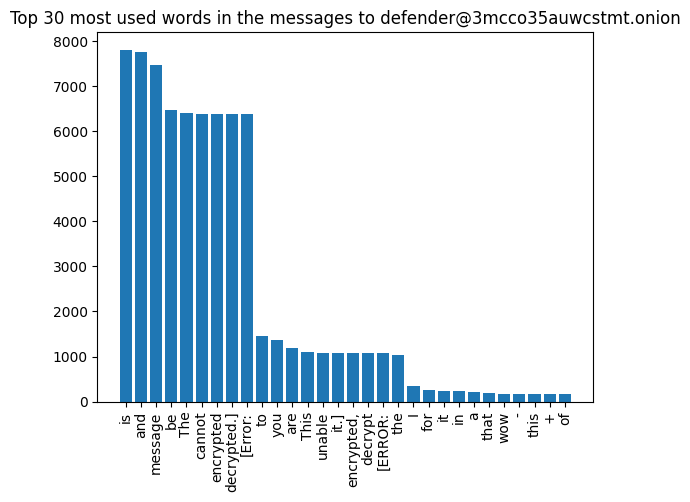

In [69]:
# Get all words that were sent to the most active person in the chat
df = pd.read_csv(file, usecols=['body_en', 'to'])
wordsToHacker = []
for index, row in df.iterrows():
    if (row.to == 'defender@q3mcco35auwcstmt.onion'):
        for string in row.body_en.split(' '):
            wordsToHacker.append(string)

# find the frequency of the words used
uniqueWords = []
occurences = []

for word in wordsToHacker:
    if word not in uniqueWords:
        uniqueWords.append(word)
        occurences.append(1)
    else:
        # find index of the string already in the uniqueWords and increment the occurences by 1
        occurences[uniqueWords.index(word)] = occurences[uniqueWords.index(word)] + 1

for word in uniqueWords:
    if word == 'pa$$word,':
        uniqueWords[uniqueWords.index('pa$$word,')] = 'password'

uniqueWordsOrdered = [x for _,x in sorted(zip(occurences,uniqueWords), reverse=True)]
occurencesOrdered = []

for word in uniqueWordsOrdered:
    occurencesOrdered.append(occurences[uniqueWords.index(word)])

plt.title("Top 30 most used words in the messages to defender@3mcco35auwcstmt.onion")
plt.xticks(rotation=90)
plt.bar(uniqueWordsOrdered[:30], occurencesOrdered[:30])

# Conclusion and Results

This thorough research into ransomware group Conti has given us a very good insight into how these hackers communicate with eachother. We found out that the biggest player in this ransomware group is **defender**, found many bitcoin wallets connected to these hackers and at what times they mostly operate. We found out that a big amount of their messages is encrypted and that they often share links with another. We can also conclude from the timezone, hours of operation, and language that they are probably a Russian hackergroup.

We hope we can be of assistance for the FBI and that this report helps them in catching this group (which leads to us getting the 15 million dollars ;))